<a href="https://colab.research.google.com/github/tracyhann/GaussianHMM_Ibogaine/blob/main/DMN_GaussianHMM_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard Gaussian Hidden Markov Model
This notebook covers the fundamental procedures for training and examining a Gaussian Hidden Markov Model (HMM). The model is designed for analyzing a single set of time series data, such as neuroimaging or electrophysiological recordings. If you need to model interactions between two sets of time series, you can look at [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb) provided in the toolbox.

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/GaussianHMM_example.ipynb).

Authors: Christine Ahrends <christine.ahrends@cfin.au.dk>

## Outline
1. [Background](#background)
2. [Example: Modelling time-varying amplitude and functional connectivity in fMRI recordings](#example-modelling)
    * [Preparation](#preparation)
    * [Load data](#load-data)
    * [Initialise and train an HMM](#initialise-hmm)
    * [Inspect model](#inspect-model)
        * [State means: Time-varying amplitude patterns](#state-means)
        * [State covariances: Time-varying functional connectivity](#state-covariances)
        * [Transition probabilities](#transition-probabilities)
        * [Viterbi path](#viterbi-path)
        * [Summary metrics](#summary-metrics)

## Background <a id="background"></a>
The HMM is a generative probabilistic model that assumes that an observed timeseries (e.g., neuroimaging or electrophysiological recordings) were generated by a sequence of hidden "states". In the Gaussian HMM, we model states as Gaussian distributions, so we assume that the observations *Y* at time point *t* were generated by a Gaussian distribution with parameters $\mu$ and $\Sigma$ when state *k* is active, i.e.:
$$Y_t\sim N(\mu^k,\Sigma^k)$$

Additionally, the HMM estimates the probabilities $\theta$ of transitioning between each pair of states, i.e., the probability that the currently active state at time point *t* is *k* given that the state at the previous timepoint *t-1* was *l*:
$$P(s_t=k|s_{t-1}=l) = \theta_{k,l}$$

And the probability $\pi$ that a segment of the timeseries starts with state *k*:
$$P(s_0=k)=\pi_k$$

When we fit the model to the observations, we  aim to estimate the parameters of the prior distributions for these parameters ($\mu$, $\Sigma$, $\theta$, and $\pi$) using variational inference.

We define the posterior estimates as
$$\gamma_{t,k}:=P(s_t=k|s_{>t},s_{<t}, Y)$$
$$\xi_{t,k,l}:=P(s_t=k,s_{t-1}=l|s_{>t},s_{<t-1},Y)$$

where $\gamma$ are the probabilities of state *k* being active at time point *t* (the state time courses) and $\xi$ are the joint state probabilities.
Instead of the state time courses, we can also use the Viterbi path, a discrete representation of which state is active at each time point.

A common application for the standard Gaussian HMM is the estimation of time-varying amplitude and functional connectivity in fMRI recordings (e.g., [Vidaurre et al., 2017](https://www.pnas.org/doi/10.1073/pnas.1705120114)).


## Example: Modelling time-varying amplitude and functional connectivity in fMRI recordings <a id="example-modelling"></a>
We will now go through an example illustrating how to fit and inspect a standard Gaussian HMM. The example uses simulated data that can be found in the `example_data` folder. The data were generated to resemble fMRI timeseries, and our goal is to estimate time-varying amplitude and functional connectivity (FC) for a group of subjects. Imagine that the data were recorded from 20 different subjects. Each subject has been recorded for 1,000 timepoints and their timeseries were extracted in a parcellation with 50 brain regions. The data *Y* here thus has dimensions ((20 subjects * 1000 timepoints), 50 brain regions). We use the *indices* array to specify where in the timeseries each of the 20 subjects' session starts and ends.

### Preparation <a id="preparation"></a>
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

**Import libraries**\
Let's start by importing the required libraries and modules.

In [ ]:
pip install glhmm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 91.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from glhmm import glhmm, preproc, utils, graphics

ModuleNotFoundError: No module named 'glhmm'

In [ ]:
!pip install nilearn

In [ ]:
import nilearn
import nibabel as nib

### Load and prepare data <a id="load-data"></a>
Example data for this tutorial are available for download from the OSF. This notebook will fetch the relevant data from the OSF project page using the osfclient package. If you prefer, you can also directly download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666) and skip the next two cells.

The standard HMM requires only one input: a timeseries `Y`. When running the model on a concatenated timeseries, e.g., a group of subjects or several scanning sessions, you also need to provide the `indices` indicating where each subject/session in the concatenated timeseries `Y` starts and ends.

Input data for the glhmm should be in numpy format. Other data types, such as .csv, can be converted to numpy using e.g. pandas, as shown below. Alternatively, the `io` module provides useful functions to load input data in the required format, e.g., from existing .mat-files. If you need to create indices from session lengths (as used in the HMM-MAR toolbox) you can use the `auxiliary.make_indices_from_T` function.

Synthetic data for this example should now be in the `glhmm/docs/notebooks/example_data` folder. The file `data.csv` contains synthetic timeseries. The data should have the shape ((no subjects/sessions * no timepoints), no features), meaning that all subjects and/or sessions have been concatenated along the first dimension. The second dimension is the number of features, e.g., the number of parcels or channels. The file `T.csv` specifies the indices in the concatenated timeseries corresponding to the beginning and end of individual subjects/sessions in the shape (no subjects, 2). In this case, we have generated timeseries for 20 subjects and 50 features. Each subject has 1,000 timepoints. The timeseries has the shape (20000, 50) and the indices have the shape (20, 2).

In [4]:
#data = pd.read_csv('./example_data/data.csv', header=None).to_numpy()
#T_t = pd.read_csv('./example_data/T.csv', header=None).to_numpy()
data = np.load('/content/data.npy')
T_t = np.load('/content/T_t.npy')
# using sub-54095s001_ses-V2 resting fMRI 1, 2 concat as example

In [ ]:
print('data.shape', data.shape)
print('T_t.shape', T_t.shape)

data.shape (60516, 37)
T_t.shape (29, 2)


In [ ]:
data, T_t

(array([[ 0.10676008, -0.04965021,  0.09542683, ...,  0.19031267,
          0.20691901, -0.03700749],
        [ 0.1848785 , -0.0834169 ,  0.1647141 , ...,  0.25658706,
          0.2534597 , -0.01598845],
        [ 0.2974637 ,  0.02574616,  0.18600929, ...,  0.31839132,
          0.27101412,  0.00832   ],
        ...,
        [-0.8058999 ,  0.47520575, -1.8589541 , ..., -1.142808  ,
         -2.006282  , -1.8343035 ],
        [-0.16129723,  0.42337078, -1.0216917 , ..., -0.82909054,
         -1.2674408 , -1.3433467 ],
        [ 0.38151002,  0.17746049,  0.17074624, ..., -0.16196334,
         -0.15869613, -0.47046104]], dtype=float32),
 array([[    0,  2214],
        [ 2214,  4428],
        [ 4428,  6642],
        [ 6642,  8856],
        [ 8856, 11070],
        [11070, 13284],
        [13284, 15498],
        [15498, 16974],
        [16974, 19188],
        [19188, 20664],
        [20664, 22878],
        [22878, 23616],
        [23616, 25830],
        [25830, 28044],
        [28044, 30258]

**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.**\
Standardising will be done separately for each session/subject as specified in the indices. The data provided here are already close to standardised (so the code below will not do much). Other preprocessing steps may be filtering or dimensionality reduction, which may be reasonable depending on the data and model variety. The preprocessing function also outputs a log to keep track of which preprocessing has been performed that can be passed on to the glhmm object. This is required if you have performed preprocessing steps that require backtransforming (PCA/ICA).

In [ ]:
data,_,log = preproc.preprocess_data(data, T_t)

### Initialise and train an HMM <a id="initialise-hmm"></a>
We first initialise the glhmm object and specify hyperparameters. In the case of the standard Gaussian HMM, since we do not want to model an interaction between two sets of variables, we set `model_beta='no'`. The number of states is specified using the `K` parameter. We here estimate `K=4` states. If you want to model a different number of states, change K to a different value. In this example, we want to model states as Gaussian distributions with a mean and full covariance matrix, so that each state is described by a mean amplitude and functional connectivity pattern. To do this, specify `covtype='full'`, the state-specific mean is already set by default. If you do not want to model the mean, add `model_mean='no'`.

In [ ]:
hmm = glhmm.glhmm(model_beta='no', K=4, covtype='full', preproclogY=log)

Optionally, you can check the hyperparameters (including the ones set by default) to make sure that they correspond to how you want the model to be set up.

In [ ]:
print(hmm.hyperparameters)

{'K': 4, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True])}


We then train the HMM using the data and indices loaded above. Since we here do not model an interaction between two sets of timeseries but run a standard HMM instead, we set `X=None`. `Y` should be the timeseries in which we want to estimate states (in here called `data`) and indices should be the beginning and end indices of each subject (here called `T_t`). During training, the output will usually show the progress in model fit at each iteration. This can be quite long, so we have here suppressed it for displaying purposes. You can remove the first line (`%%capture`) to show it.

In [ ]:
%%capture
np.random.seed(123)
hmm.train(X=None, Y=data, indices=T_t)

Optionally, you can also return `Gamma` (the state probabilities at each timepoint), `Xi` (the joint probabilities of past and future states conditioned on the data) and `FE` (the free energy of each iteration) at this step, but it is also possible to retrieve them later using the `decode` function for Gamma and Xi and the `get_fe` function for the free energy.

In [ ]:
%%capture
np.random.seed(123)
Gamma,Xi,FE = hmm.train(X=None, Y=data, indices=T_t)

### Inspect model <a id="inspect-model"></a>
We can then inspect some interesting aspects of the model. We start by checking what the states look like by interrogating the state means and the state covariances. We will then look at the dynamics, i.e., how states transition between each other (transition probabilities) and how the state sequence develops over time (the Viterbi path). Finally, we will have a look at some summary metrics that can be useful to describe the overall patterns or to relate the model to behaviour using [statistical testing](./Testing_across_sessions_within_subject.ipynb) or [machine learning/out-of-sample prediction](./Prediction_tutorial.ipynb).
> We here show some simple result plots. For more plotting options, see the [Graphics](../../glhmm/graphics.py) module

#### State means: Time-varying amplitude patterns <a id="state-means"></a>
The state means can be interpreted as time-varying patterns of amplitude (relative to the baseline). They can be retrieved from the model using the `get_means()` function, or `get_mean(k)` to retrieve only the mean for state `k`:

In [ ]:
K = hmm.hyperparameters["K"] # the number of states
q = data.shape[1] # the number of parcels/channels
state_means = np.zeros(shape=(q, K))
state_means = hmm.get_means() # the state means in the shape (no. features, no. states)

We can then plot these amplitude patterns. This will show the states on the x-axis, each parcel/brain region/channel on the y-axis, and the mean activation of each parcel in each state as the color intensity.

In [ ]:
state_means.shape

(37, 4)

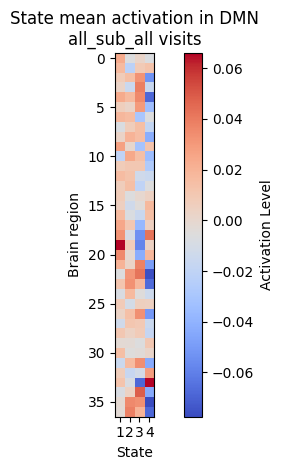

In [ ]:
cmap = "coolwarm"
plt.imshow(state_means, cmap=cmap,interpolation="none")
plt.colorbar(label='Activation Level') # Label for color bar
plt.title("State mean activation in DMN\nall_sub_all visits")
plt.xticks(np.arange(K), np.arange(1,K+1))
plt.gca().set_xlabel('State')
plt.gca().set_ylabel('Brain region')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### State covariances: Time-varying functional connectivity <a id="state-covariances"></a>
The state covariances represent the time-varying functional connectivity patterns that we have estimated in the fMRI recordings. They can be obtained from the model using the `get_covariance_matrix` function:

In [ ]:
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = hmm.get_covariance_matrix(k=k) # the state covariance matrices in the shape (no. features, no. features, no. states)

In [ ]:
state_FC

array([[[ 0.93005958,  1.15044183,  1.25214169,  0.6032251 ],
        [ 0.54656466,  0.77732582,  0.66704663,  0.41470249],
        [ 0.5956025 ,  0.76416568,  0.70750603,  0.40011115],
        ...,
        [ 0.09894919,  0.53731001,  0.33875592,  0.26480883],
        [ 0.27458159,  0.1594945 ,  0.19703044,  0.09961424],
        [-0.0440451 , -0.12857763, -0.10152064, -0.0970025 ]],

       [[ 0.54656466,  0.77732582,  0.66704663,  0.41470249],
        [ 0.98597594,  1.16587499,  1.1966627 ,  0.59852634],
        [ 0.31090109,  0.6159588 ,  0.59746969,  0.34996642],
        ...,
        [ 0.16211266,  0.54607981,  0.27773943,  0.23997879],
        [ 0.31433779,  0.3042898 ,  0.32347026,  0.1679709 ],
        [ 0.06741268,  0.05588501,  0.06384516, -0.01802676]],

       [[ 0.5956025 ,  0.76416568,  0.70750603,  0.40011115],
        [ 0.31090109,  0.6159588 ,  0.59746969,  0.34996642],
        [ 0.90087914,  1.1722729 ,  1.25961137,  0.58047808],
        ...,
        [ 0.05002007,  0.69

In [ ]:
dmn_idx = pd.read_csv('/content/schaefer2018_DMNrois.csv')
dmn_idx = dmn_idx.to_dict()
dmn_idx = dmn_idx['0']

rows = []
for k in range(K):
  fc = state_FC[:,:,k]
  for i in range(len(fc)):
    for j in range(len(fc)):
      rows.append({'state':k, 'from':dmn_idx[i], 'to':dmn_idx[j], 'fc':fc[i,j]})
fc_df = pd.DataFrame(rows)
fc_df.sort_values(by=['state', 'from', 'fc'], ascending=True)
fc_df.to_csv('state_FC_all_visits.csv')

We can then plot the covariance (i.e., functional connectivity) of each state. These are square matrices showing the brain region by brain region functional connectivity patterns:

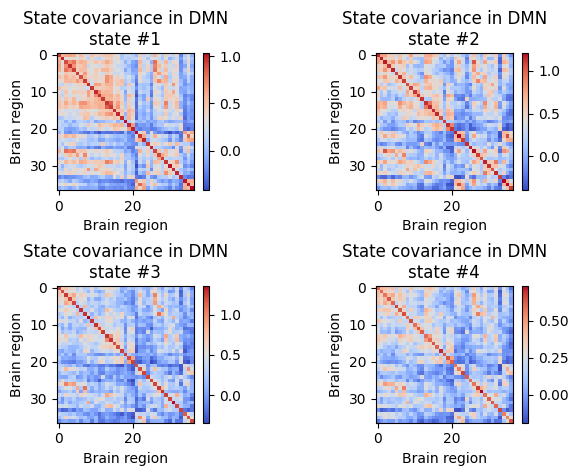

In [ ]:
for k in range(K):
    plt.subplot(2,2,k+1)
    plt.imshow(state_FC[:,:,k],cmap=cmap)
    plt.xlabel('Brain region')
    plt.ylabel('Brain region')
    plt.colorbar()
    plt.title("State covariance in DMN\nstate #%s" % (k+1))
plt.subplots_adjust(hspace=0.7, wspace=0.8)
plt.show()

In [ ]:
from nilearn import plotting, datasets
atlas = datasets.atlas.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=17,resolution_mm=2)

[fetch_atlas_schaefer_2018] Added README.md to /root/nilearn_data

[fetch_atlas_schaefer_2018] Dataset created in /root/nilearn_data/schaefer_2018

[fetch_atlas_schaefer_2018] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_17Networks_order.txt ...

[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

[fetch_atlas_schaefer_2018] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_17Networks_order_FSLMNI152_2mm
.nii.gz ...

[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

In [ ]:
from nilearn import plotting

# returns an array of shape (n_rois, 3) in MNI space (x, y, z)
coords = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

In [ ]:
dmn_idx = []
for i in range(len(atlas.labels[1:])):
  if 'Default' in atlas.labels[i]:
    dmn_idx.append(i)
print('Found ', len(dmn_idx), ' DMN coordinates.')

Found  37  DMN coordinates.


In [ ]:
from nilearn import plotting, datasets

def state_cov_network_plot(coords, dmn_idx, state_FC, k, html=False):
  coords = coords[dmn_idx]
  n_rois = len(coords)

  cov = state_FC[:,:,k]
  # Take upper triangle values
  i, j = np.triu_indices_from(cov, k=1)
  vals = cov[i, j]

  # Choose a threshold (e.g., top 5% strongest |cov| values)
  perc = 0
  thr = np.percentile(np.abs(vals), perc)

  cov_thr = cov.copy()
  cov_thr[np.abs(cov_thr) < thr] = 0

  plotting.plot_connectome(
      cov_thr,
      coords,
      node_size=20,
      edge_cmap='cold_hot',
      edge_vmin=-np.max(np.abs(cov_thr)),  # symmetric colormap
      edge_vmax= np.max(np.abs(cov_thr)),
      display_mode='l',    # lateral view ('l', 'r', 'lr', 'ortho', etc.)
      colorbar=True,
      title=f"State #{k} covariance in DMN",
      figure=plt.figure(figsize=(6,4), ),
      black_bg = False

  )

  plotting.show()

  if html == True:
    view = plotting.view_connectome(
    cov_thr,
    coords,
    edge_cmap='cold_hot',
    symmetric_cmap=True,
    node_size=5,
    title="State covariance in DMN\nstate #%s" % (k+1),
    title_fontsize=25
    )
    view.save_as_html(f"state{k}_cov_net.html")



/tmp/ipython-input-220638728.py:19: UserWarning: 'adjacency_matrix' is not symmetric.
A directed graph will be plotted.
  plotting.plot_connectome(


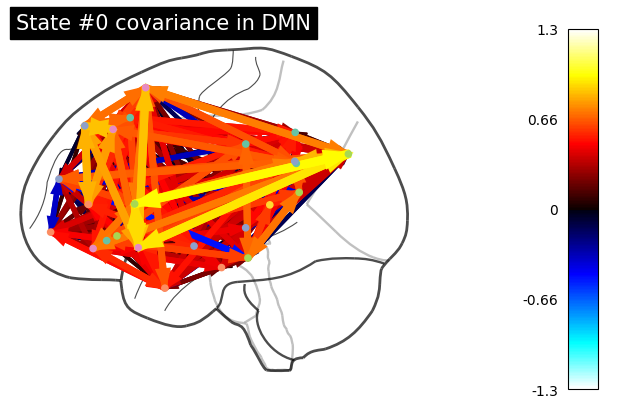

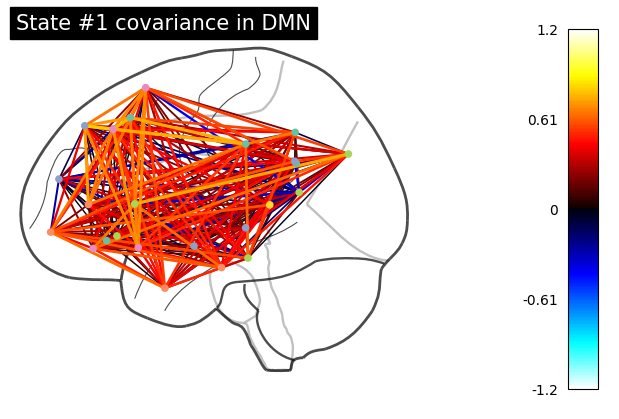

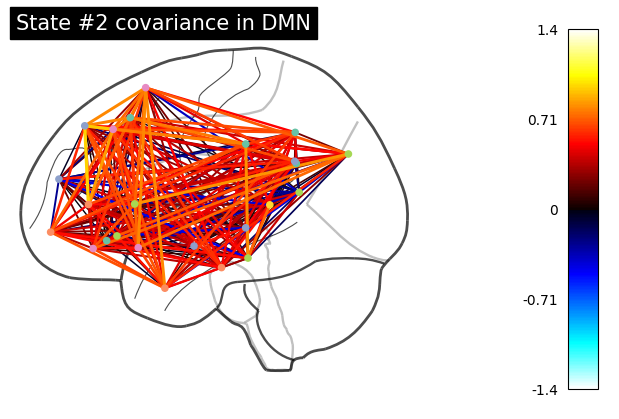

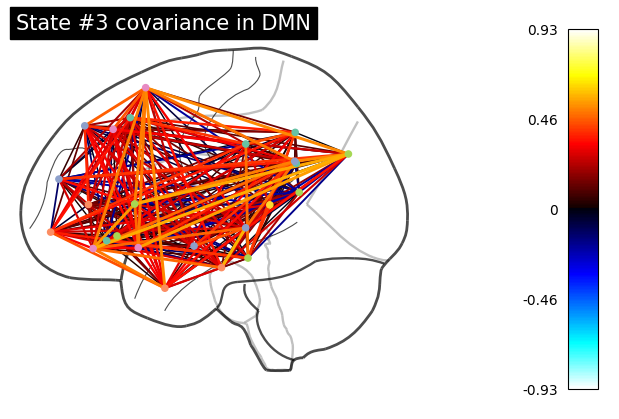

In [ ]:
for k in range(K):
  state_cov_network_plot(coords, dmn_idx, state_FC, k, html=True)

#### Transition probabilities <a id="transition-probabilities"></a>
The transition probabilities indicate the temporal order in the state sequence, i.e., the probability of transitioning from any one state to any other state. They are contained in `hmm.P` with a shape of [K, K]:

In [ ]:
TP = hmm.P.copy() # the transition probability matrix

In [ ]:
hmm.__dict__

{'hyperparameters': {'K': 4,
  'covtype': 'full',
  'model_mean': 'state',
  'model_beta': 'no',
  'dirichlet_diag': 10,
  'connectivity': None,
  'Pstructure': array([[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]),
  'Pistructure': array([ True,  True,  True,  True])},
 'beta': None,
 'mean': [{'Mu': array([ 0.02287532,  0.01710739,  0.00727016,  0.00244534,  0.02301461,
           0.00616052,  0.01820258, -0.00777391,  0.00246195,  0.0269446 ,
          -0.01992757,  0.0072486 ,  0.01609373,  0.00682636,  0.00768572,
           0.00538271,  0.0166281 ,  0.02501364,  0.03220697,  0.06595056,
           0.03570323,  0.01983563, -0.00626959,  0.01148524, -0.00834907,
           0.00795796,  0.00278539, -0.01295455,  0.01015173, -0.001915  ,
           0.01480973, -0.01476332,  0.00712752,  0.01193795, -0.00811234,
          -0.0015143 , -0.00266792]),
   'Sigma': array([[ 9.98860820e-05,

We can then plot the transition probability matrix. Note that self-transitions (i.e., staying in the same state) are considerably more likely in a timeseries that has some order, so there should be a strong diagonal pattern. For comparison, we also show the transition probabilities excluding self-transitions:

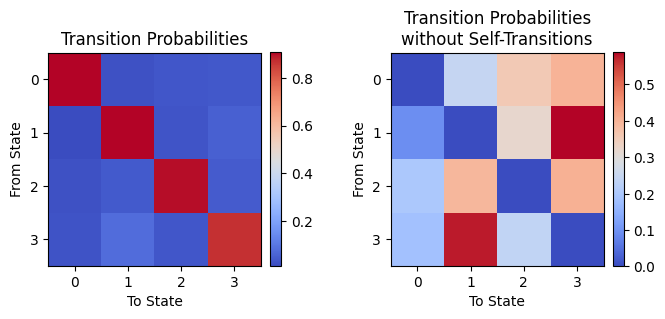

In [ ]:
# Plot Transition Probabilities
plt.figure(figsize=(7, 4))

# Plot 1: Original Transition Probabilities
plt.subplot(1, 2, 1)
plt.imshow(TP, cmap=cmap, interpolation='nearest')  # Improved color mapping
plt.title('Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.colorbar(fraction=0.046, pad=0.04)

# Plot 2: Transition Probabilities without Self-Transitions
TP_noself = TP - np.diag(np.diag(TP))  # Remove self-transitions
TP_noself2 = TP_noself / TP_noself.sum(axis=1, keepdims=True)  # Normalize probabilities
plt.subplot(1, 2, 2)
plt.imshow(TP_noself2, cmap=cmap, interpolation='nearest')  # Improved color mapping
plt.title('Transition Probabilities\nwithout Self-Transitions')
plt.xlabel('To State')
plt.ylabel('From State')
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


#### Viterbi path <a id="viterbi-path"></a>
The Viterbi path is a discrete representation of the state timecourse, indicating which state is active at which timepoint. We may be able to see whether some states tend to occur more for certain subjects, or are related to a stimulus that occurs at specific timepoints. The Viterbi path can also be informative to understand whether the HMM is "mixing", i.e., states occur across subjects, or whether the model estimates the entire session of one subject as one state (see [Ahrends et al. 2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9361391/)).
You can retrieve the Viterbi path using the `decode` function and setting `viterbi=True`:

In [ ]:
import pickle
with open('/content/T_t_visits.pkl', 'rb') as f:
    T_t_visits = pickle.load(f)
T_t_visits

{'V2': [[0, 738],
  [2214, 2952],
  [4428, 5166],
  [6642, 7380],
  [8856, 9594],
  [11070, 11808],
  [13284, 14022],
  [15498, 16236],
  [16974, 17712],
  [19188, 19926],
  [20664, 21402],
  [22878, 23616],
  [23616, 24354],
  [25830, 26568],
  [28044, 28782],
  [30258, 30996],
  [32472, 33210],
  [34686, 35424],
  [36900, 37638],
  [39114, 39852],
  [41328, 42066],
  [43542, 44280],
  [45018, 45756],
  [47232, 47970],
  [49446, 50184],
  [51660, 52398],
  [53874, 54612],
  [56088, 56826],
  [58302, 59040]],
 'V3': [[738, 1476],
  [2952, 3690],
  [5166, 5904],
  [7380, 8118],
  [9594, 10332],
  [11808, 12546],
  [14022, 14760],
  [16236, 16974],
  [17712, 18450],
  [19926, 20664],
  [21402, 22140],
  [23616, 23616],
  [24354, 25092],
  [26568, 27306],
  [28782, 29520],
  [30996, 31734],
  [33210, 33948],
  [35424, 36162],
  [37638, 38376],
  [39852, 40590],
  [42066, 42804],
  [44280, 45018],
  [45756, 46494],
  [47970, 48708],
  [50184, 50922],
  [52398, 53136],
  [54612, 55350],
  [

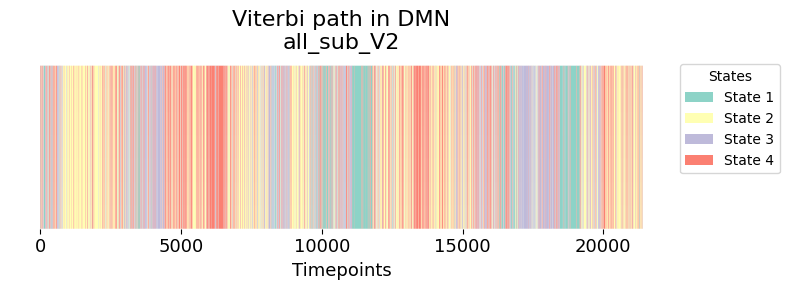

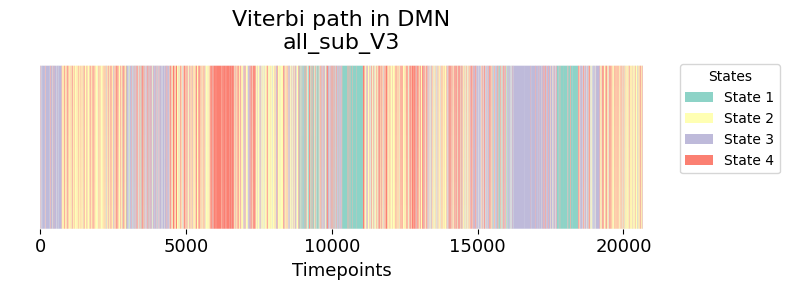

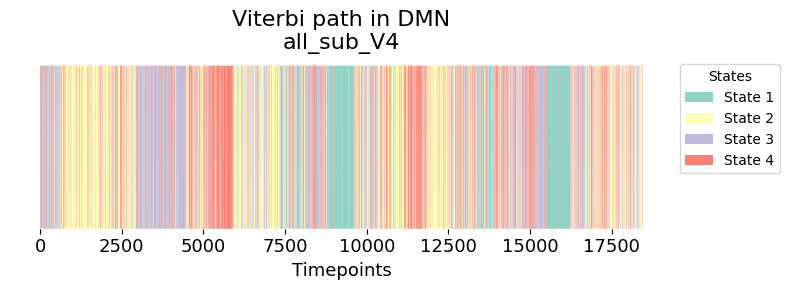

In [ ]:
for visit in ['V2', 'V3', 'V4']:
  ranges = T_t_visits[visit]          # list of [start, end]
  lengths = np.array([e - s for s, e in ranges], dtype=int)
  data_visit = np.concatenate([data[s:e] for s, e in ranges], axis=0)
  starts = np.concatenate(([0], np.cumsum(lengths)[:-1]))
  ends   = starts + lengths
  ranges_visit = np.stack([starts, ends], axis=1).tolist()
  vpath = hmm.decode(X=None, Y=data_visit, indices=np.array(ranges_visit), viterbi=True)
  graphics.plot_vpath(vpath, title=f"Viterbi path in DMN\nall_sub_{visit}", figsize=(8,3))

And plot the Viterbi path (see also `graphics` module):

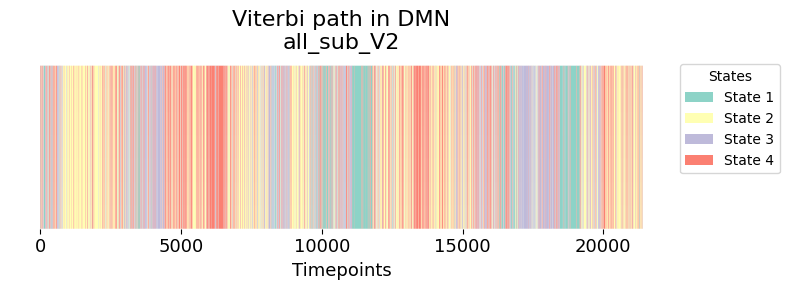

/usr/local/lib/python3.12/dist-packages/glhmm/auxiliary.py:349: RuntimeWarning: invalid value encountered in divide
  delta[0,:,:] = delta[0,:,:] / np.expand_dims(np.sum(delta[0,:,:],axis=1),axis=1)


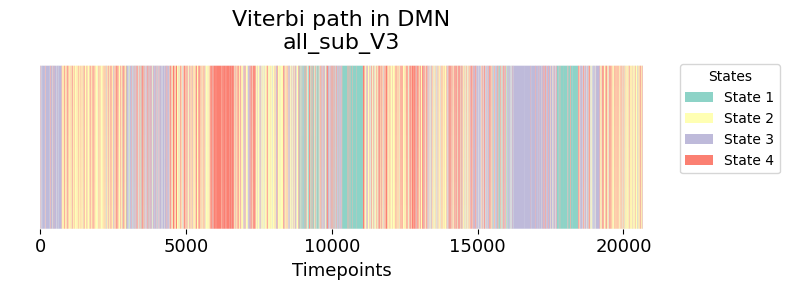

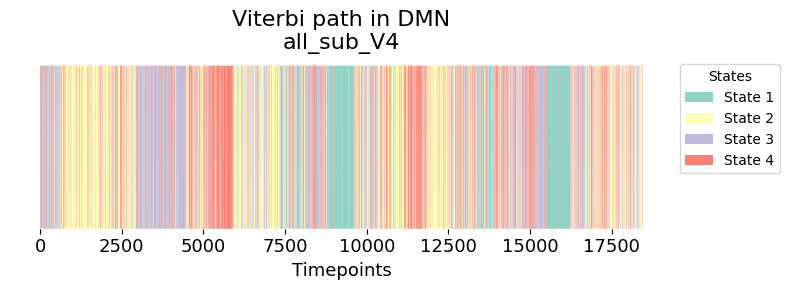

In [ ]:
for visit in ['V2', 'V3', 'V4']:
  ranges = T_t_visits[visit]          # list of [start, end]
  lengths = np.array([e - s for s, e in ranges], dtype=int)
  data_visit = np.concatenate([data[s:e] for s, e in ranges], axis=0)
  starts = np.concatenate(([0], np.cumsum(lengths)[:-1]))
  ends   = starts + lengths
  ranges_visit = np.stack([starts, ends], axis=1).tolist()
  vpath = hmm.decode(X=None, Y=data_visit, indices=np.array(ranges_visit), viterbi=True)
  graphics.plot_vpath(vpath, title=f"Viterbi path in DMN\nall_sub_{visit}", figsize=(8,3))

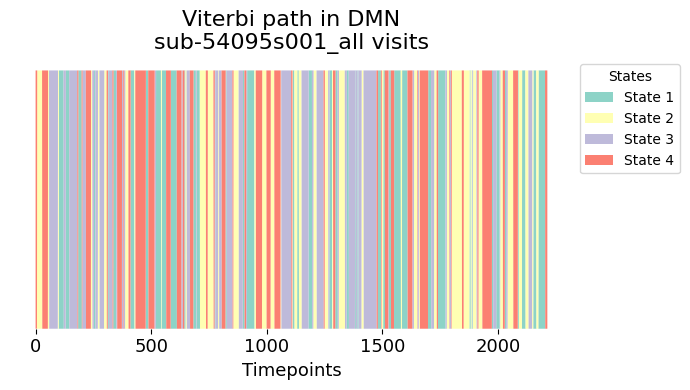

In [ ]:
graphics.plot_vpath(vpath, title="Viterbi path in DMN\nsub-54095s001_all visits")

#### Summary metrics <a id="summary-metrics"></a>
Once we have estimated the model parameters, we can compute some summary metrics to describe the patterns we see more broadly. These summary metrics can be useful to relate patterns in the timeseries to behaviour, using e.g., statistical testing (see [Statistical testing tutorial](./Testing_across_subjects.ipynb)) or machine learning (see [Prediction tutorial](./Prediction_tutorial.ipynb)). The module `utils` provides useful functions to obtain these summary metrics.

The *fractional occupancy (FO)* indicates the fraction of time in each session that is occupied by each state. For instance, if one state was active for the entire duration of the session, this state's FO would be 1 (100%) and all others would be 0. If, on the other hand, all states are present for an equal amount of timepoints in total, the FO of all states would be 1/*K* (the number of states). This can be informative to understand whether one state is more present in a certain group of subjects or experimental condition, or to interrogate mixing (explained above).

You can obtain the fractional occupancies using the `get_FO` function. The output is an array containing the FO of each subject along the first dimension and each state along the second dimension.

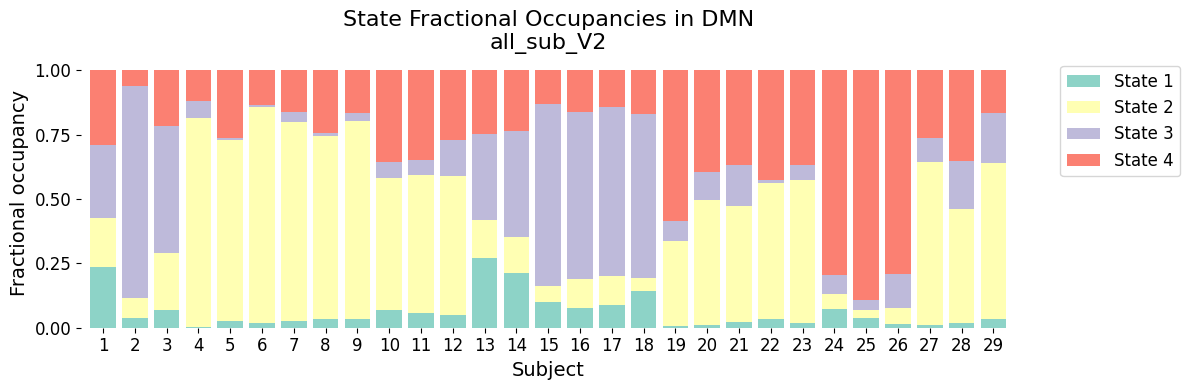

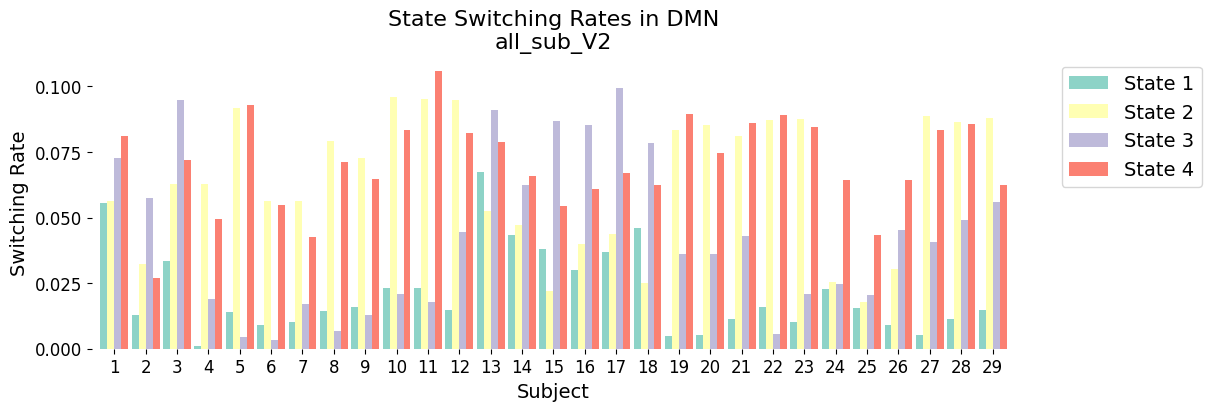

/usr/local/lib/python3.12/dist-packages/glhmm/utils.py:39: RuntimeWarning: invalid value encountered in divide
  FO[j,:] /= np.sum(FO[j,:])


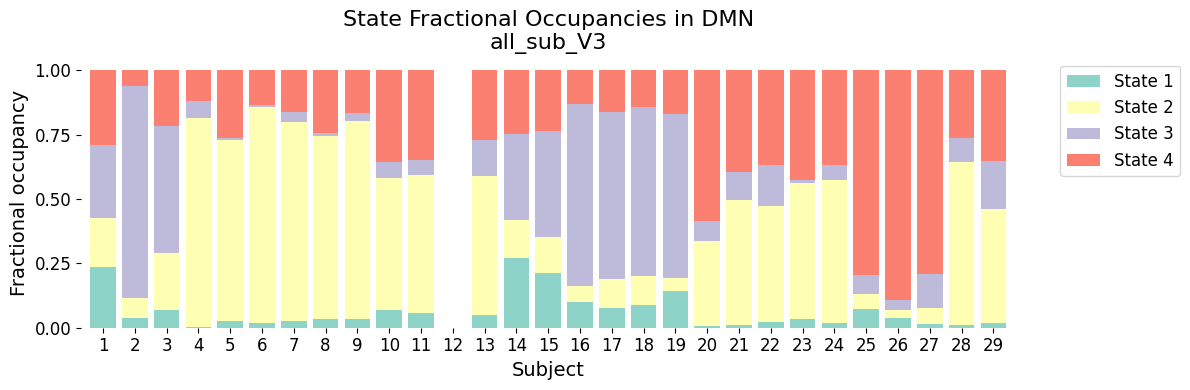

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


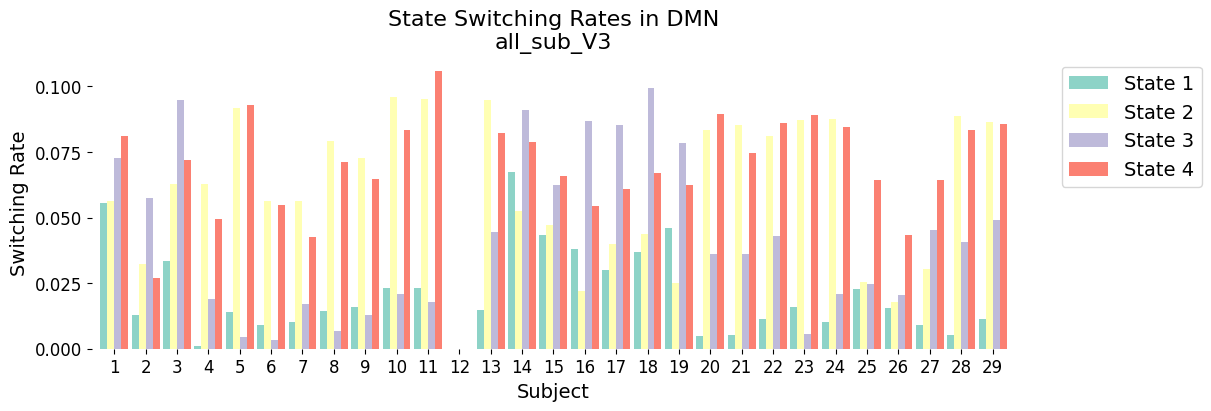

/usr/local/lib/python3.12/dist-packages/glhmm/utils.py:39: RuntimeWarning: invalid value encountered in divide
  FO[j,:] /= np.sum(FO[j,:])


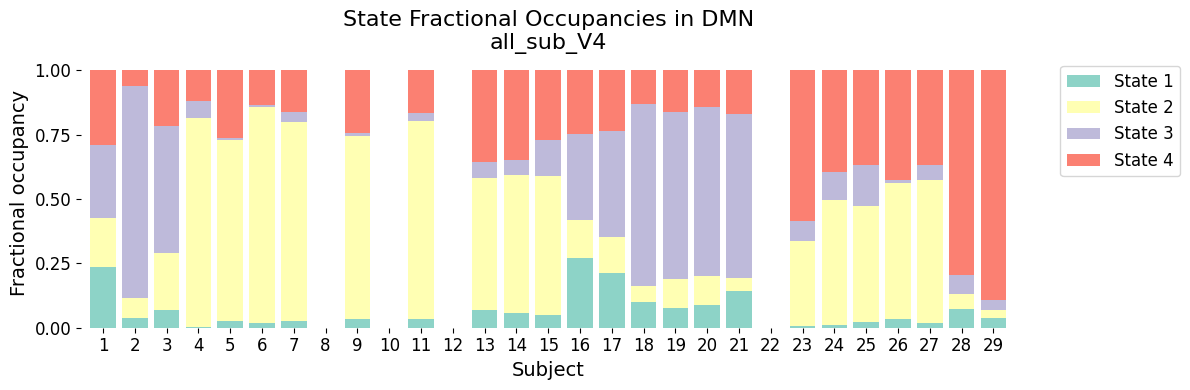

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


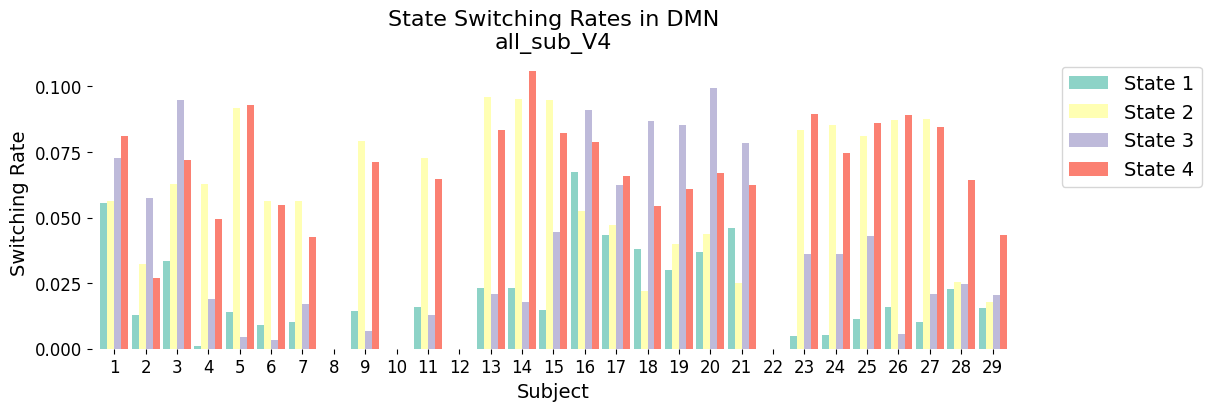

In [ ]:
for visit in ['V2', 'V3', 'V4']:
  ranges = T_t_visits[visit]          # list of [start, end]
  lengths = np.array([e - s for s, e in ranges], dtype=int)
  data_visit = np.concatenate([data[s:e] for s, e in ranges], axis=0)
  starts = np.concatenate(([0], np.cumsum(lengths)[:-1]))
  ends   = starts + lengths
  ranges_visit = np.stack([starts, ends], axis=1).tolist()
  FO = utils.get_FO(Gamma, indices=np.array(ranges_visit))
  graphics.plot_FO(FO, num_x_ticks=FO.shape[0], title=f'State Fractional Occupancies in DMN\nall_sub_{visit}', figsize=(12,4))
  SR = utils.get_switching_rate(Gamma, indices=np.array(ranges_visit))
  graphics.plot_switching_rates(SR, num_x_ticks=SR.shape[0], title = f'State Switching Rates in DMN\nall_sub_{visit}', figsize=(12,4))